### 이미지 불러오기

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import seaborn as sns
import natsort
import albumentations as A
import torch


from ipywidgets import interact
from PIL import Image
from glob import glob

In [2]:
# 원본 데이터 불러오기
o_image_path = "../Datasets/Train/images/"
o_mask_path = "../Datasets/Train/masks/"

images_paths = glob(o_image_path+"*.jpg")
masks_paths = glob(o_mask_path + "*.png")

images_paths = natsort.natsorted(images_paths)
masks_paths = natsort.natsorted(masks_paths)

df_origin = pd.DataFrame({'images': images_paths, 'masks': masks_paths})
df_origin.head(5)

,images,masks
0,../Datasets/Train/images\1.jpg,../Datasets/Train/masks\1_mask.png
1,../Datasets/Train/images\2.jpg,../Datasets/Train/masks\2_mask.png
2,../Datasets/Train/images\3.jpg,../Datasets/Train/masks\3_mask.png
3,../Datasets/Train/images\4.jpg,../Datasets/Train/masks\4_mask.png
4,../Datasets/Train/images\5.jpg,../Datasets/Train/masks\5_mask.png


In [13]:
# Image Augmentation
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, 
                       border_mode=cv2.BORDER_REFLECT, p=1),
    A.RandomCrop(width=320, height=320),
])

In [14]:
# Load datas

class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = self.df.iloc[index].images
        mask_path = self.df.iloc[index].masks

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, 0) // 255
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        
        return image, mask

In [15]:
ds = SegmentationDataset(df_origin, transform=transform)

In [11]:
@interact(index=(0, len(df_origin)-1))
def show_images(index=0):
    image = cv2.imread(df_origin.iloc[index].images)
    mask = cv2.imread(df_origin.iloc[index].masks)

    plt.figure(figsize=(12,10))
    plt.subplot(121)
    plt.title("image")
    plt.imshow(image)
    plt.subplot(122)
    plt.title("mask")
    plt.imshow(mask)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=634), Output()), _dom_classes=('widget-inter…

### Alpha blending

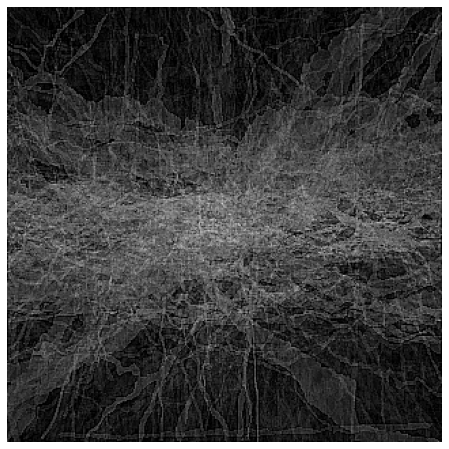

In [91]:

# 원본 이미지

dst = cv2.imread(df_origin.iloc[0].masks)
dst = cv2.resize(dst,(320, 320))

for i in range(0, len(df_origin)):
    if i == 0:
        pass
    else:
        img = cv2.imread(df_origin.iloc[i].masks)
        img = cv2.resize(img, (320,320))
        alpha = 1.0/(i+1)
        beta = 1.0 - alpha
        dst = cv2.addWeighted(img, alpha, dst, beta, 0)
        kernel = np.array([[-1,-1,-1], [-1,10,-1], [-1,-1,-1]])
        im = cv2.filter2D(dst, -1, kernel)
        
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(im)

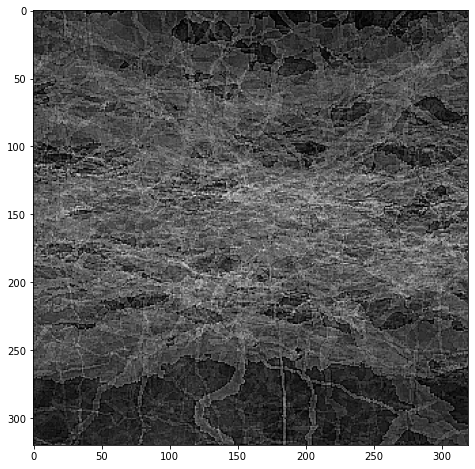

In [20]:
# cropped 이미지

dst = ds[0][1] * 255

for i in range(0, len(df_origin)):
    if i == 0:
        pass
    else:
        img = ds[i][1] * 255
        alpha = 1.0/(i+1)
        beta = 1.0 - alpha
        dst = cv2.addWeighted(img, alpha, dst, beta, 0)
        kernel = np.array([[-1,-1,-1], [-1,10,-1], [-1,-1,-1]])
        new_im = cv2.filter2D(dst, -1, kernel)
plt.figure(figsize=(8,8))
plt.imshow(new_im, cmap='gray')

### Crack rate

In [121]:
df_origin.head(5)

,images,masks,rate
0,../Datasets/Train/images\1.jpg,../Datasets/Train/masks\1_mask.png,1.19
1,../Datasets/Train/images\2.jpg,../Datasets/Train/masks\2_mask.png,3.25
2,../Datasets/Train/images\3.jpg,../Datasets/Train/masks\3_mask.png,1.58
3,../Datasets/Train/images\4.jpg,../Datasets/Train/masks\4_mask.png,1.13
4,../Datasets/Train/images\5.jpg,../Datasets/Train/masks\5_mask.png,1.13


In [122]:
rate = []

for i in range(len(df_origin)):
    
    # 계산하기 편하도록 이미지를 GrayScale로 변환
    msk = cv2.imread(df_origin.iloc[i].masks)
    msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
    h, w = msk.shape

    white_pixel = np.sum(msk==255)
    black_pixel = np.sum(msk==0)

    res = round(white_pixel/(h*w) * 100, 2) # (균열 픽셀 수)/(전체 픽셀)X100 으로 균열이 이미지에서 차지하는 비율을 구한다.
    rate.append(res)

In [123]:
df_origin['rate'] = rate
df_origin.head(5)

,images,masks,rate
0,../Datasets/Train/images\1.jpg,../Datasets/Train/masks\1_mask.png,1.19
1,../Datasets/Train/images\2.jpg,../Datasets/Train/masks\2_mask.png,3.25
2,../Datasets/Train/images\3.jpg,../Datasets/Train/masks\3_mask.png,1.58
3,../Datasets/Train/images\4.jpg,../Datasets/Train/masks\4_mask.png,1.13
4,../Datasets/Train/images\5.jpg,../Datasets/Train/masks\5_mask.png,1.13


In [132]:
df_rate = df_origin.copy()

In [133]:
df_rate.images = [i for i in range(len(df_rate))]
df_rate.head(5)

,images,masks,rate
0,0,../Datasets/Train/masks\1_mask.png,1.19
1,1,../Datasets/Train/masks\2_mask.png,3.25
2,2,../Datasets/Train/masks\3_mask.png,1.58
3,3,../Datasets/Train/masks\4_mask.png,1.13
4,4,../Datasets/Train/masks\5_mask.png,1.13


In [134]:
df_rate['rate'].describe()

count    635.000000
mean       3.087008
std        2.733552
min        0.260000
25%        1.245000
50%        2.320000
75%        4.050000
max       19.250000
Name: rate, dtype: float64

<AxesSubplot:xlabel='images', ylabel='rate'>

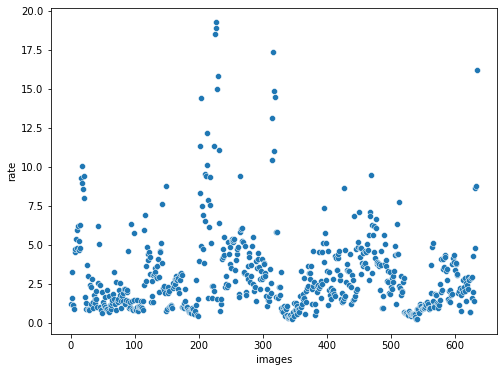

In [135]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='images', y='rate', data=df_rate)

In [136]:
def rate_range(rate):
    if rate <= 1:
        return "0~1%"
    elif rate <= 2:
        return "1~2%"
    elif rate <= 3:
        return "2~3%"
    elif rate <= 4:
        return "3~4%"
    elif rate <= 5:
        return "4~5%"
    elif rate <= 6:
        return "5~6%"
    elif rate <= 7:
        return "6~7%"
    elif rate <= 8:
        return "7~8%"
    elif rate <= 9:
        return "8~9%"
    else:
        return "9~100%"

In [137]:
df_rate['rate_range'] = df_rate['rate'].apply(rate_range)
df_rate.head(5)

,images,masks,rate,rate_range
0,0,../Datasets/Train/masks\1_mask.png,1.19,1~2%
1,1,../Datasets/Train/masks\2_mask.png,3.25,3~4%
2,2,../Datasets/Train/masks\3_mask.png,1.58,1~2%
3,3,../Datasets/Train/masks\4_mask.png,1.13,1~2%
4,4,../Datasets/Train/masks\5_mask.png,1.13,1~2%


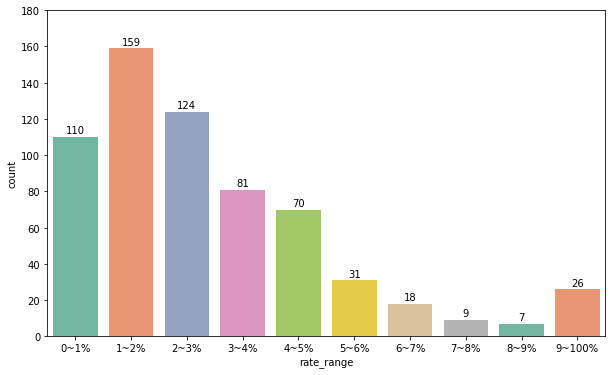

In [139]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=df_rate, x=df_rate['rate_range'].sort_values(), palette="Set2")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height+2, height, ha = 'center', size = 10)
ax.set_ylim(0, 180)
plt.show()